# EDGES-3 IO usage

This notebook gives usage of accessing EDGES-3 files using edges-analysis

Author: Akshatha Vydula

Date: Oct 27, 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob  import glob
from edges_cal.s11 import VNAReading
from edges_cal.s11 import StandardsReadings
import pandas as pd
from edges_analysis import GSData
import astropy.units as u
from datetime import datetime, timedelta

import edges3io as e3

from edges_cal import CalibrationObservation, LoadSpectrum, Receiver, LoadS11
from edges_cal.cal_coefficients import Load
from edges_cal.tools import FrequencyRange
from read_acq import read_acq

root_dir = '/data5/edges/data/EDGES3_data/MRO' #this is where the raw files are 
akshatha_dir = '/data4/vydula/edges/edges3-data-analysis/scripts/meta_data_files/' #this is where output files will be

In [2]:
#define date and load here

load = ['hot', 'open', 'short', 'amb', 'ant','lna']  #should be one of hot, open, short, amb, ant, lna

year = '2023'

day ='003'


file_list = e3.get_s1p_files(load[1], year, day)

res ={'open':1e9, 'short':0, 'load':49.962}

print(file_list)

{'input': '/data5/edges/data/EDGES3_data/MRO/2023_003_00_open.s1p', 'open': '/data5/edges/data/EDGES3_data/MRO/2023_003_00_O.s1p', 'short': '/data5/edges/data/EDGES3_data/MRO/2023_003_00_S.s1p', 'match': '/data5/edges/data/EDGES3_data/MRO/2023_003_00_L.s1p'}


In [3]:
for i in range(len(load)):
    if(load[i] == 'lna'):
        s11, freq, vna_s11 = e3.gets11(load[i], year, day, cablen=4.34, cabdiel= -1.64, cabloss = -90.6);

    else:
        s11, freq, vna_s11  = e3.gets11(load[i], year, day);

    df = pd.DataFrame({'freq': freq,'s11_real':np.real(s11), 's11_imag': np.imag(s11)})
    df.to_csv(akshatha_dir+f's11_{load[i]}.csv',index=False)

/data4/vydula/edges/packages/edges-io/src/edges_io/io.py:871: UserWarning: Non standard line in S11 file /data5/edges/data/EDGES3_data/MRO/2023_003_00_L.s1p: 'BEGIN
'
...Treating as a comment line.
  warnings.warn(
/data4/vydula/edges/packages/edges-io/src/edges_io/io.py:871: UserWarning: Non standard line in S11 file /data5/edges/data/EDGES3_data/MRO/2023_003_00_O.s1p: 'BEGIN
'
...Treating as a comment line.
  warnings.warn(
/data4/vydula/edges/packages/edges-io/src/edges_io/io.py:871: UserWarning: Non standard line in S11 file /data5/edges/data/EDGES3_data/MRO/2023_003_00_S.s1p: 'BEGIN
'
...Treating as a comment line.
  warnings.warn(
/data4/vydula/edges/packages/edges-io/src/edges_io/io.py:871: UserWarning: Non standard line in S11 file /data5/edges/data/EDGES3_data/MRO/2023_003_00_hot.s1p: 'BEGIN
'
...Treating as a comment line.
  warnings.warn(
/data4/vydula/edges/packages/edges-io/src/edges_io/io.py:871: UserWarning: Non standard line in S11 file /data5/edges/data/EDGES3_data/MRO

In [4]:
s11_lna = pd.read_csv(akshatha_dir+'s11_lna.csv')
s11_open = pd.read_csv(akshatha_dir+'s11_open.csv')
s11_short = pd.read_csv(akshatha_dir+'s11_short.csv')
s11_amb = pd.read_csv(akshatha_dir+'s11_amb.csv')
s11_hot = pd.read_csv(akshatha_dir+'s11_hot.csv')

freq = freq

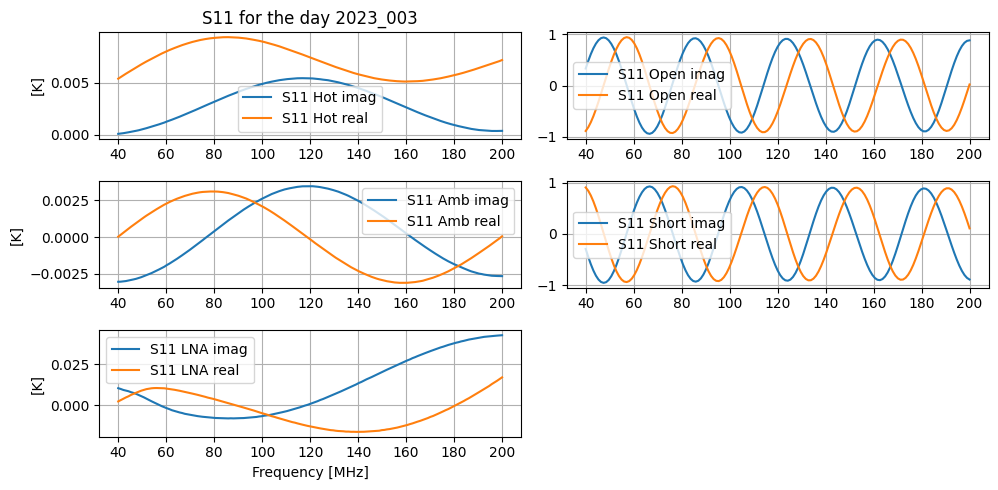

In [5]:
plt.figure(figsize = (10,5))


plt.subplot(321)
plt.plot(freq/1e6, s11_hot['s11_imag'], label='S11 Hot imag')
plt.plot(freq/1e6, s11_hot['s11_real'], label='S11 Hot real')
plt.legend()
plt.grid()
plt.ylabel('[K]')
plt.title('S11 for the day '+ year+'_' +day)

plt.subplot(322)
plt.plot(freq/1e6, s11_open['s11_imag'], label='S11 Open imag')
plt.plot(freq/1e6, s11_open['s11_real'], label='S11 Open real')
plt.legend()
plt.grid()

plt.subplot(323)
plt.plot(freq/1e6, s11_amb['s11_imag'], label='S11 Amb imag')
plt.plot(freq/1e6, s11_amb['s11_real'], label='S11 Amb real')
plt.legend()
plt.grid()
plt.ylabel('[K]')


plt.subplot(324)
plt.plot(freq/1e6, s11_short['s11_imag'], label='S11 Short imag')
plt.plot(freq/1e6, s11_short['s11_real'], label='S11 Short real')
plt.legend()
plt.grid()



plt.subplot(325)
plt.plot(freq/1e6, s11_lna['s11_imag'], label='S11 LNA imag')
plt.plot(freq/1e6, s11_lna['s11_real'], label='S11 LNA real')
plt.legend()
plt.grid()
plt.xlabel('Frequency [MHz]')
plt.ylabel('[K]')

plt.tight_layout()

### Next step is creating objects as defined for EDGES-2 in edges-analysis

We need Receiver object, LoadS11 Object, Load Spectrum Object.

Alan's approach:


For each of the calibration loads (amb, hot, open, short): 
    1. run ```acqplota7moon``` to average the ACQ files (and get rid of some RFI etc, if it exists). These are written to spe_{load}.txt.
    2. pass all of those spectra .txt files (at this point they are literally just a single averaged spectrum per load) plus a file containing all the S11's of the loads, to ```edges3.c```, that spits out a single specal.txt file which has all the calibration info in it, similar to the .h5 output from ```CalibrationObservation``` in ```edges-cal```
    
    
Similar approach with existing edges-analysis tools:


```edges_cal.CalibrationObservation``` object can be used to create directly from an ```edges_io.CalibrationObservation``` object (using the ```edges_cal.CalibrationObservation.from_io()```  classmethod). That takes in all the spectra and S11's of the calibration loads (and LNA), and does the linear solution for the noise-waves. It has an attribute containing a ```Spectrum``` class that essentially does what ```acqplota7moo```n does for Alan (reading and averaging the ACQ files).


We can create new ```.from_io``` method for the ```CalibrationObservation``` object

To make ```CalibrationObservation``` object:

    ```loads: dict[str, Load] = attr.ib()
    receiver: s11.Receiver = attr.ib()
    cterms: int = attr.ib(default=5, kw_only=True)
    wterms: int = attr.ib(default=7, kw_only=True)```


For ```Load``` objects, one per calibration load, and they each need:


    ```spectrum: LoadSpectrum = attr.ib()
    reflections: s11.LoadS11 = attr.ib()
    _loss_model: Callable[
        [np.ndarray], np.ndarray] | HotLoadCorrection | None = attr.ib(default=None)
    ambient_temperature: float = attr.ib(default=298.0)```


The reflections here should just be a ```LoadS11``` object, which is essentially just the S11 already calculated using ```edges3io.get_s11()```. 

The ```LoadSpectrum``` needs:

    ```freq: FrequencyRange = attr.ib()
    q: np.ndarray = attr.ib(
        eq=attr.cmp_using(eq=partial(np.array_equal, equal_nan=True)))
    variance: np.ndarray | None = attr.ib(
        eq=attr.cmp_using(eq=partial(np.array_equal, equal_nan=True)))
    n_integrations: int = attr.ib()
    temp_ave: float = attr.ib()
    t_load_ns: float = attr.ib(300, 0)
    t_load: float = attr.ib(400.0)
    _metadata: dict[str, Any] = attr.ib(default=attr.Factory(dict))```
    
    

In [6]:
f_low = 40*u.MHz
f_high = 190*u.MHz

#create Receiver obj

freq = FrequencyRange(f=s11_lna['freq'].values*u.Hz, f_low = f_low, f_high =f_high)

rcv = Receiver(raw_s11 = s11_lna['s11_real'].values + 1j*s11_lna['s11_imag'].values, freq= freq)

In [7]:
#create LoadS11 obj

s11_obj_hot = LoadS11(raw_s11= s11_hot['s11_real'].values + 1j*s11_hot['s11_imag'].values, 
                      freq = freq, internal_switch=None)

s11_obj_amb = LoadS11(raw_s11= s11_amb['s11_real'].values + 1j*s11_amb['s11_imag'].values, 
                      freq = freq, internal_switch=None)

s11_obj_open = LoadS11(raw_s11= s11_open['s11_real'].values + 1j*s11_open['s11_imag'].values, 
                      freq = freq, internal_switch=None)

s11_obj_short = LoadS11(raw_s11= s11_short['s11_real'].values + 1j*s11_short['s11_imag'].values, 
                      freq = freq, internal_switch=None)

In [8]:
#default Alan's temperatures


# amb_temp = open_temp = short_temp = 305
# hot_temp = 395.5


##### Temperatures from temperature logs

this needs ancillary output from read_acq.decode (for datetime infrmation). 
e3.extract_dates and e3.extract_temp_values_from_logger only needs to run once, and it spits out a temperature.csv file, which is used in the subsequent steps.

In [9]:
#create LoadSpectrum obj

#for ambiant load
q_amb,p_amb,anc_amb = read_acq.decode_file(root_dir+'/mro/amb/2023/2023_070_12_43_06_amb.acq', meta=True);

#first ten rows of q are nans (frequencies), and also discarding first 10 times so discarding those

q_amb = q_amb[11:,0:]
freq_amb = FrequencyRange(f=anc_amb.frequencies[11:]*u.MHz, f_low = f_low, f_high =f_high)

#to get temperature
start_time, end_time = e3.extract_dates(anc_amb)
temperature_file = e3.extract_temp_values_from_logger(root_dir+'/temperature_logger/temperature.log')
amb_temp = e3.extract_temperature(anc_amb, load='amb', temperature_file=temperature_file)

load_spec_obj_amb = LoadSpectrum(q=q_amb.mean(axis=1)[freq_amb.mask], freq = freq_amb, 
                                 variance= np.var(q_amb, axis=1)[freq_amb.mask],
                                n_integrations= q_amb[0,:].shape[0], temp_ave= amb_temp.value, t_load=300, t_load_ns= 1000);



#for hot load
q_hot,p_hot,anc_hot = read_acq.decode_file(root_dir+'/mro/hot/2023/2023_070_15_39_25_hot.acq', meta=True);

#first ten rows of q are nans (frequencies), and also discarding first 10 times so discarding those

q_hot = q_hot[10:,0:]
freq_hot = FrequencyRange(f=anc_hot.frequencies[10:]*u.MHz, f_low = f_low, f_high =f_high)

hot_temp = e3.extract_temperature(anc_hot, load ='hot')

load_spec_obj_hot = LoadSpectrum(q=q_hot.mean(axis=1)[freq_hot.mask], freq = freq_hot,
                                 variance= np.var(q_hot, axis=1)[freq_hot.mask],
                                n_integrations= q_hot[0,:].shape[0], temp_ave= hot_temp.value, t_load=300, t_load_ns= 1000);


#for open load
q_open,p_open,anc_open = read_acq.decode_file(root_dir+'/mro/open/2023/2023_070_18_35_43_open.acq', meta=True);

#first ten rows of q are nans (frequencies), and also discarding first 10 times so discarding those

q_open = q_open[10:,0:]
freq_open = FrequencyRange(f=anc_open.frequencies[10:]*u.MHz, f_low = f_low, f_high =f_high)

open_temp = e3.extract_temperature(anc_open, load='open')

load_spec_obj_open = LoadSpectrum(q=q_open.mean(axis=1)[freq_open.mask], freq = freq_open,
                                  variance= np.var(q_open, axis=1)[freq_open.mask],
                                n_integrations= q_open[0,:].shape[0], temp_ave= open_temp.value, t_load=300, t_load_ns= 1000);


#for short load
q_short,p_short,anc_short = read_acq.decode_file(root_dir+'/mro/short/2023/2023_070_21_32_02_short.acq', meta=True);

#first ten rows of q are nans (frequencies), and also discarding first 10 times so discarding those

q_short = q_short[10:,0:]
freq_short = FrequencyRange(f=anc_short.frequencies[10:]*u.MHz, f_low = f_low, f_high =f_high)

short_temp = e3.extract_temperature(anc_short, load='short')

load_spec_obj_short = LoadSpectrum(q=q_short.mean(axis=1)[freq_short.mask], freq = freq_short, 
                                   variance= np.var(q_short, axis=1)[freq_short.mask],
                                n_integrations= q_short[0,:].shape[0], temp_ave= short_temp.value, t_load=300, t_load_ns= 1000);


Reading 2023_070_12_43_06_amb.acq: 1349lines [00:03, 344.58lines/s]
/home/vydula/src/anaconda/envs/edges/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/vydula/src/anaconda/envs/edges/lib/python3.11/site-packages/numpy/core/_methods.py:215: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/vydula/src/anaconda/envs/edges/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
Reading 2023_070_15_39_25_hot.acq: 1349lines [00:03, 344.32lines/s]
/home/vydula/src/anaconda/envs/edges/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/vydula/src/anaconda/envs/edges/lib/python3.11/site

## Comparison b/w Alan and EA for averaged spectra

In [10]:
alan_spec_hot = pd.read_csv("/home/vydula/data4/vydula/edges/edges3-data-analysis/scripts/alan_scripts_edges3/scripts/sphot.txt",
                           delimiter=r'\s+', names =['freq', 'spectra', 'weight'], skiprows=1)


alan_spec_short = pd.read_csv("/home/vydula/data4/vydula/edges/edges3-data-analysis/scripts/alan_scripts_edges3/scripts/spshort.txt",
                           delimiter=r'\s+', names =['freq', 'spectra', 'weight'], skiprows=1)

alan_spec_open = pd.read_csv("/home/vydula/data4/vydula/edges/edges3-data-analysis/scripts/alan_scripts_edges3/scripts/spopen.txt",
                           delimiter=r'\s+', names =['freq', 'spectra', 'weight'], skiprows=1)

alan_spec_amb = pd.read_csv("/home/vydula/data4/vydula/edges/edges3-data-analysis/scripts/alan_scripts_edges3/scripts/spamb.txt",
                           delimiter=r'\s+', names =['freq', 'spectra', 'weight'], skiprows=1)

/home/vydula/src/anaconda/envs/edges/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


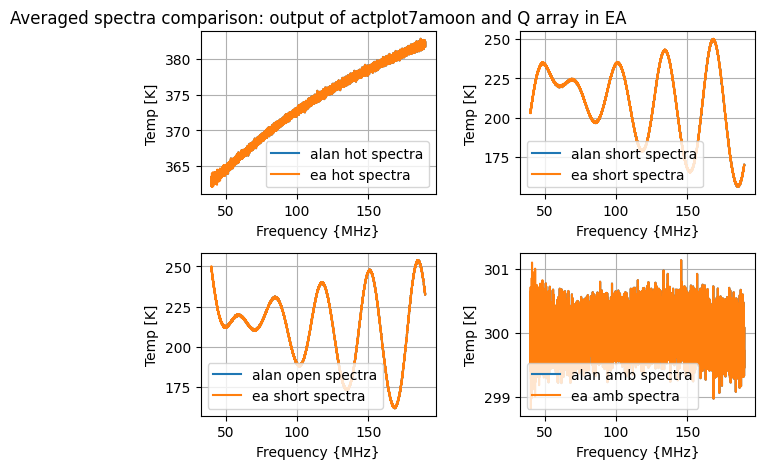

In [11]:
plt.figure()


plt.subplot(221)
plt.plot(alan_spec_hot['freq'], alan_spec_hot['spectra'], label='alan hot spectra')
plt.plot(freq_hot.freq ,q_hot.mean(axis=1)[freq_hot.mask]*1000+300, label='ea hot spectra' )
plt.legend()
plt.xlabel('Frequency {MHz}')
plt.ylabel('Temp [K]')
plt.grid()
plt.title('Averaged spectra comparison: output of actplot7amoon and Q array in EA')


plt.subplot(222)
plt.plot(alan_spec_short['freq'], alan_spec_short['spectra'], label='alan short spectra')
plt.plot(freq_short.freq ,q_short.mean(axis=1)[freq_short.mask]*1000+300, label='ea short spectra' )
plt.xlabel('Frequency {MHz}')
plt.legend()
plt.xlabel('Frequency {MHz}')
plt.ylabel('Temp [K]')
plt.grid()


plt.subplot(223)
plt.plot(alan_spec_open['freq'], alan_spec_open['spectra'], label='alan open spectra')
plt.plot(freq_open.freq ,q_open.mean(axis=1)[freq_open.mask]*1000+300, label='ea short spectra' )
plt.legend()
plt.xlabel('Frequency {MHz}')
plt.ylabel('Temp [K]')
plt.grid()


plt.subplot(224)
plt.plot(alan_spec_amb['freq'], alan_spec_amb['spectra'], label='alan amb spectra')
plt.plot(freq_amb.freq ,q_amb.mean(axis=1)[freq_amb.mask]*1000+300, label='ea amb spectra' )

plt.legend()
plt.xlabel('Frequency {MHz}')
plt.ylabel('Temp [K]')
plt.grid()

plt.tight_layout()
#plt.savefig('averaged_spectra_comparison.jpeg')


In [12]:
loads = {'hot_load': Load(spectrum=load_spec_obj_hot, reflections=s11_obj_hot),
        'ambient': Load(spectrum=load_spec_obj_amb, reflections=s11_obj_amb),
        'open': Load(spectrum=load_spec_obj_open, reflections=s11_obj_open),
        'short': Load(spectrum=load_spec_obj_short, reflections=s11_obj_short)}

In [13]:
cal_obj = CalibrationObservation(loads= loads, receiver=rcv, wterms=6, cterms=5)


In [14]:
#save all the polynomial coefficients

np.savez(akshatha_dir+'polynomial_coeff.npz', C1 = np.array(cal_obj.C1_poly), C2 = np.array(cal_obj.C2_poly),
        Tcos = np.array(cal_obj.Tcos_poly), Tsin = np.array(cal_obj.Tsin_poly), Tunc = np.array(cal_obj.Tunc_poly),
         wterms= cal_obj.wterms, cterms = cal_obj.cterms, t_load = cal_obj.t_load, t_load_ns = cal_obj.t_load_ns,
        freq = cal_obj.freq.freq, Tsin_polynomial = getattr(cal_obj, 'Tsin')(), 
         Tcos_polynomial = getattr(cal_obj, 'Tcos')(), Tunc_polynomial = getattr(cal_obj, 'Tunc')(),
        C1_polynomial = getattr(cal_obj, 'C1')(), C2_polynomial = getattr(cal_obj, 'C2')())

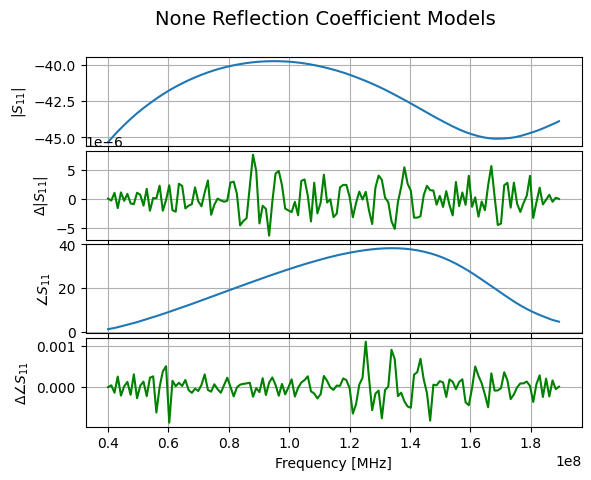

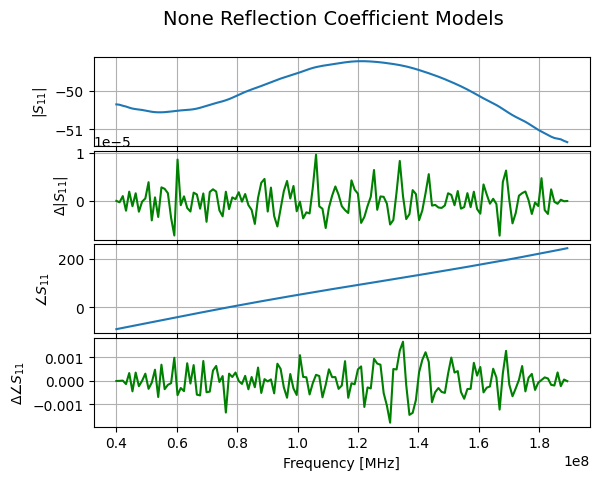

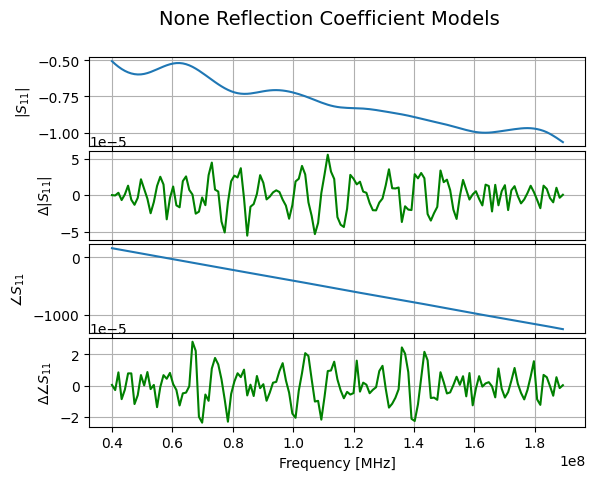

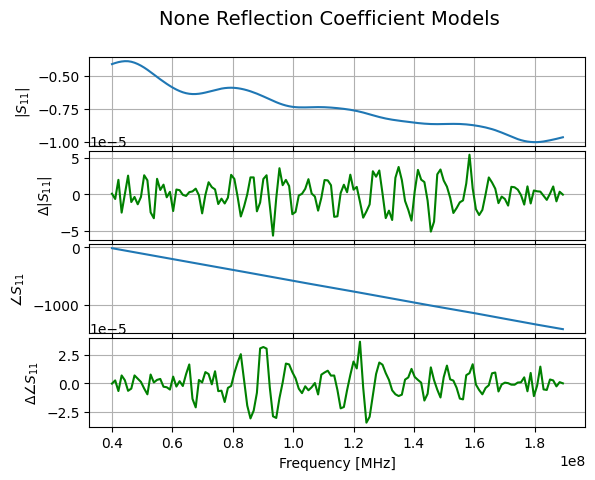

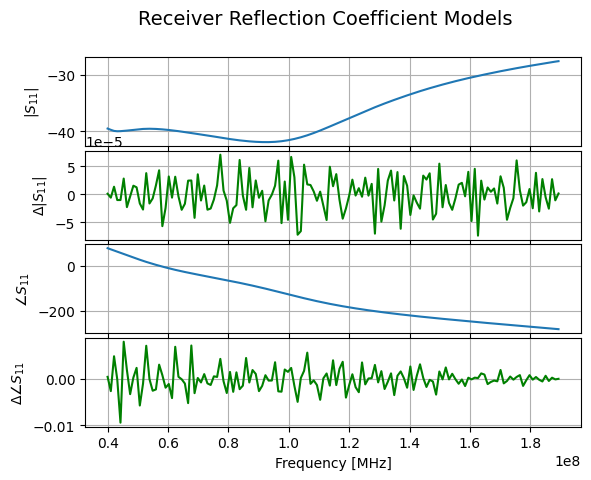

In [15]:
cal_obj.plot_s11_models();

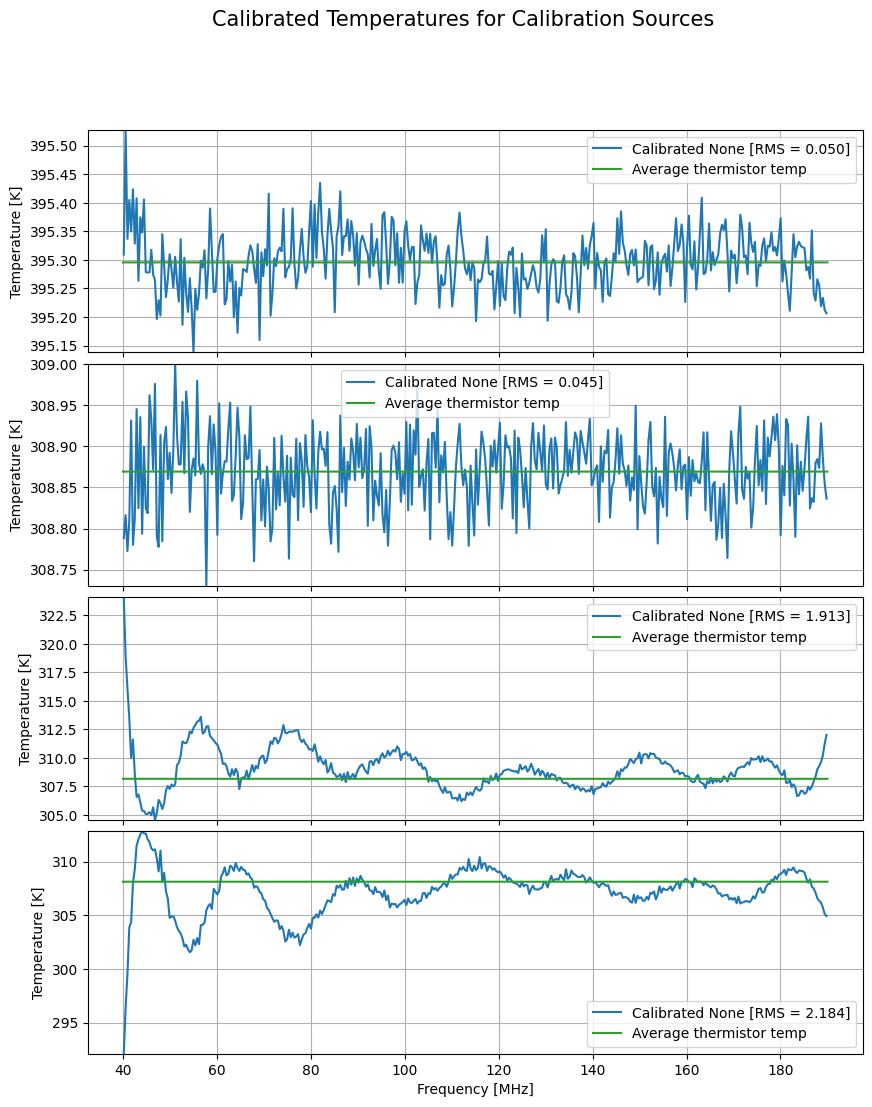

In [16]:
cal_obj.plot_calibrated_temps();

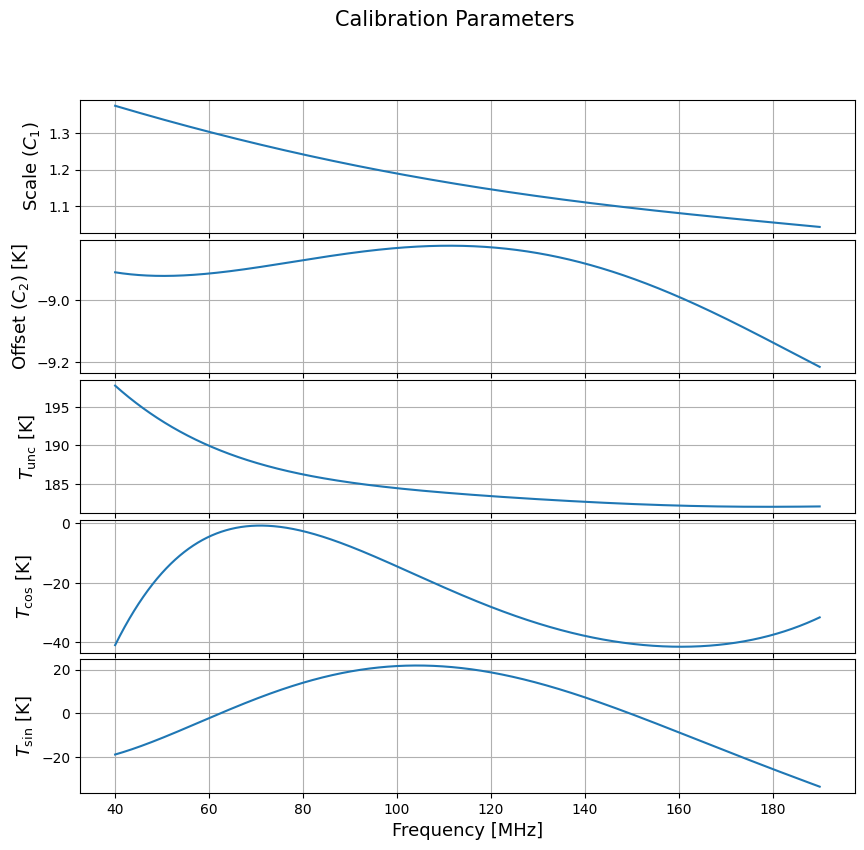

In [17]:
cal_obj.plot_coefficients();

## Comparison between Alan and EA for calibration


In [18]:
alan_cal_hot = pd.read_csv("/home/vydula/data4/vydula/edges/edges3-data-analysis/scripts/alan_scripts_edges3/scripts/specal.txt",
                           
                           delimiter=r'\s+', names=['freq_name','freq', 's11lna_name', 's11lna_real', 's11lna_imag', 'sca',  'C1', 
                                           'ofs', 'C2', 'tlnau', 'Tunc', 'tlnac', 'Tcos', 'tlnas', 'Tsin', 
                                           'wtcal', 'wtcal_value', 'cal_data'])


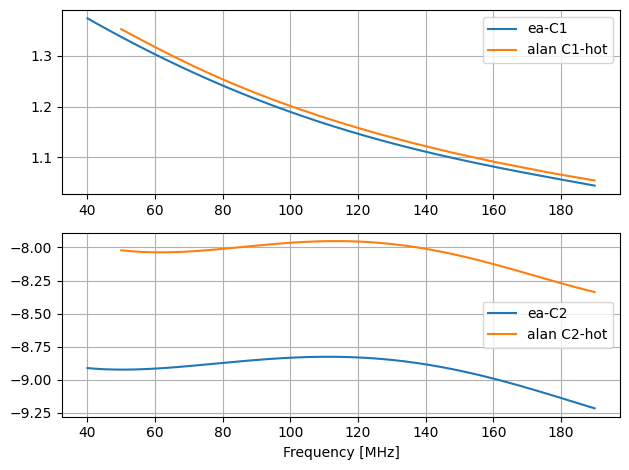

In [19]:
plt.figure()
plt.subplot(211)
plt.plot(cal_obj.freq.freq, getattr(cal_obj, "C1")(), label='ea-C1')
plt.plot(alan_cal_hot['freq'], alan_cal_hot['C1'], label='alan C1-hot')
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(cal_obj.freq.freq, getattr(cal_obj, "C2")(), label='ea-C2')
plt.plot(alan_cal_hot['freq'], alan_cal_hot['C2'], label='alan C2-hot')

plt.grid()
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.tight_layout()

### Save the output to a .h5 file

In [20]:
cal_obj.write(akshatha_dir+'2023_070_ea.h5')

/home/vydula/src/anaconda/envs/edges/lib/python3.11/site-packages/hickle/lookup.py:1491: SerializedWarning: 'YAMLObjectMetaclass' type not understood, data is serialized:
  warnings.warn(
